In [155]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree, feature_selection
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier

## Classification 

### Data cleaning

In [2]:
df = pd.read_csv('adult.csv')

In [3]:
df.head(5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


there is unknown values that has ? in the dataset, I use replace to transform it to nan values

In [5]:
df = df.replace('?', np.nan) #replace ? with the nan values

In [6]:
df.isnull().sum() #check the nan values

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

In [7]:
df.dropna(inplace = True) #drop nan values as it is hard to fill the nan values for those columns

### Data engineering

In [8]:
df['income'] = df['income'].map({'>50K': 0, '<=50K': 1})

In [9]:
from sklearn.preprocessing import LabelEncoder
for col in df.columns:
    if df[col].dtypes == 'object':         
        encoder = LabelEncoder()         
        df[col] = encoder.fit_transform(df[col])

After label encoding, the education and educational-num has same values, therefore, I drop the educational-num column

In [10]:
df.drop(columns = ['educational-num'], inplace = True ) 

In [11]:
print(f'Percentage of income <=50k {(df.income.value_counts()[1]/len(df))*100}')
print(f'Percentage of income >50k {(df.income.value_counts()[0]/len(df))*100}')

Percentage of income <=50k 75.21560302507629
Percentage of income >50k 24.78439697492371


In [12]:
df.income.value_counts()

1    34014
0    11208
Name: income, dtype: int64

<BarContainer object of 2 artists>

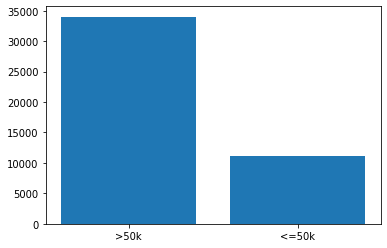

In [13]:
plt.bar (height = df.income.value_counts().values, x = ['>50k', '<=50k']  )

This shows the imbalance of the dataset

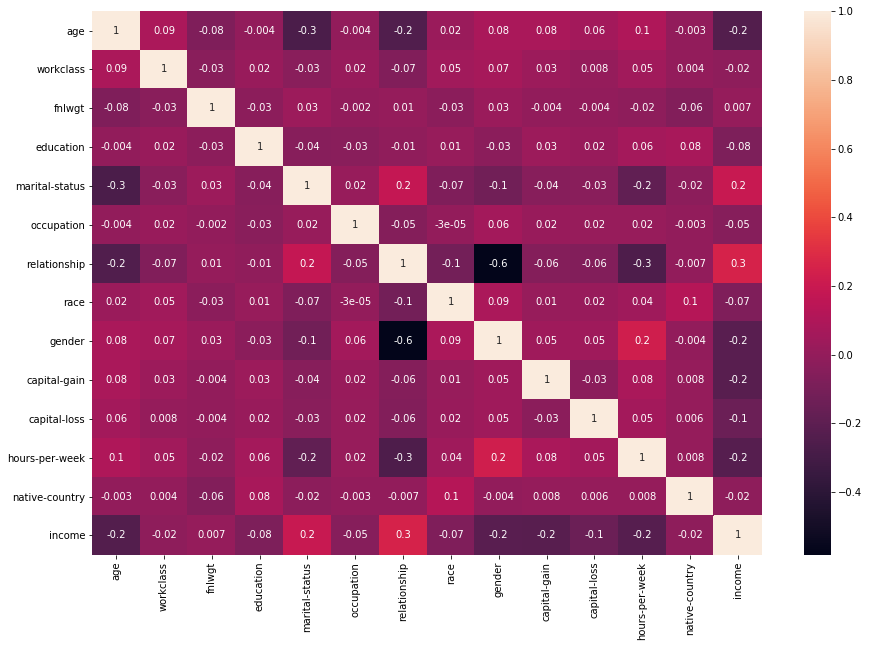

In [14]:
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(), annot = True, fmt='.1g')

In [15]:
X = df.drop(['income'], axis = 1)
y = df['income']

As the data is imbalanced, I used RandomOverSampler to balance the data

In [16]:
ros=RandomOverSampler(random_state=0)
X_resample,y_resample=ros.fit_sample(X,y)
print(X_resample.shape)
print(y_resample.shape)

(68028, 13)
(68028,)


### Random forest

In [17]:
X_train, X_test, y_train, y_test = train_test_split (X_resample, y_resample)

In [18]:
rdf = RandomForestClassifier(random_state=42)
rdf.fit(X_train, y_train)
print(rdf.score(X_train, y_train))
print(rdf.score(X_test, y_test))

0.9999020011367868
0.9262656553183983


In [19]:
for name,score in zip(df.columns,rdf.feature_importances_):
    print(f"{name}:{np.round(score,2)}")

age:0.16
workclass:0.03
fnlwgt:0.16
education:0.08
marital-status:0.11
occupation:0.07
relationship:0.14
race:0.01
gender:0.01
capital-gain:0.09
capital-loss:0.03
hours-per-week:0.08
native-country:0.01


The important features are age, fnlwgt,education, marital-status, ocupation, relationship, capital-gain, hours-per-week. So I created a new dataframe that includes the important features. 

In [20]:
new_df = df[['age', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'capital-gain', 'hours-per-week']]

In [21]:
new_df.head(5)

,age,fnlwgt,education,marital-status,occupation,relationship,capital-gain,hours-per-week
0,25,226802,1,4,6,3,0,40
1,38,89814,11,2,4,0,0,50
2,28,336951,7,2,10,0,0,40
3,44,160323,15,2,6,0,7688,40
5,34,198693,0,4,7,1,0,30


In [22]:
X_new = new_df
y_new = df['income']

As the data is imbalance, RandomOverSampler is used.

In [23]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split (X_new, y_new, test_size = 0.2)

In [24]:
rdf = RandomForestClassifier(random_state=42)
rdf.fit(X_train_1, y_train_1)
print(rdf.score(X_train_1, y_train_1))
print(rdf.score(X_test_1, y_test_1))

0.9998894325123697
0.8337202874516307


In [25]:
param_grid = {
    'max_depth': [10,20],
    'max_leaf_nodes': [10,20,30],
    'n_estimators': [100, 200]}

In [26]:
grid = GridSearchCV(estimator = rdf, param_grid = param_grid, n_jobs = -1)

In [27]:
grid.fit(X_train_1, y_train_1)

GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'max_leaf_nodes': [10, 20, 30],
                         'n_estimators': [100, 200]})

In [28]:
grid.best_estimator_

RandomForestClassifier(max_depth=20, max_leaf_nodes=30, n_estimators=200,
                       random_state=42)

In [151]:
rdf = RandomForestClassifier(random_state=42, max_depth = 20, max_leaf_nodes = 30)
rdf.fit(X_train_1, y_train_1)
print(rdf.score(X_train_1, y_train_1))
print(rdf.score(X_test_1, y_test_1))

0.8476932857893137
0.8422332780541736


### SVM

In [30]:
selector=feature_selection.SelectKBest(k=8,score_func=feature_selection.mutual_info_regression)

In [31]:
df_news = selector.fit_transform(X_resample,y_resample)

In [32]:
print(df_news.shape)
df_news[:5, :]

(68028, 8)


array([[  25,    1,    4,    6,    3,    1,    0,   40],
       [  38,   11,    2,    4,    0,    1,    0,   50],
       [  28,    7,    2,   10,    0,    1,    0,   40],
       [  44,   15,    2,    6,    0,    1, 7688,   40],
       [  34,    0,    4,    7,    1,    1,    0,   30]])

The selected features are age, education, marital-status, occupation, relationship, gender, capital-gain, hours-per-week

In [33]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_news, y_resample)

In [129]:
svc = SVC(kernel="rbf",C=10,gamma=0.001)
svc.fit(X_train_2, y_train_2)

SVC(C=10, gamma=0.001)

In [130]:
print(svc.score(X_train_2, y_train_2))
print(svc.score(X_test_2, y_test_2))

0.8093922110503519
0.8066090433350973


In [131]:
y_pred = svc.predict(X_test_2)
accuracy_score(y_pred, y_test_2)

0.8066090433350973

In [36]:
# params = {'C': [0.001, 0.01, 0.1, 1],
#         'gamma': [0.01, 0.1, 1, 10]}

In [37]:
# grid = GridSearchCV(estimator = svc, param_grid = params , n_jobs = -1)
# grid.fit(X_train_2, y_train_2)

In [38]:
# grid.best_estimator_

### Logistic Regression

In [117]:
pipe = Pipeline([("scaler", StandardScaler()),
                 ("logreg", LogisticRegression(C=0.01, max_iter = 1000, penalty = 'l2'))])
pipe.fit(X_train_2, y_train_2)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(C=0.01, max_iter=1000))])

In [118]:
print(pipe.score(X_train_2, y_train_2))
print(pipe.score(X_test_2, y_test_2))

0.730150330256169
0.7308755218439467


In [113]:
# LRparam_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#     'penalty': ['l2'],
#     'max_iter': [800,900,1000],
# }

In [111]:
y_pred = pipe.predict(X_test_2)
accuracy_score(y_pred, y_test_2)

0.7308755218439467

### Hard voting

In [156]:
log_clf=LogisticRegression(C=0.01, max_iter = 1000, penalty = 'l2')
rnd_clf=RandomForestClassifier(random_state=42, max_depth = 20, max_leaf_nodes = 30)
svm_clf=SVC(kernel="rbf",C=10,gamma=0.001)

voting_clf=VotingClassifier(
    [("lr",log_clf),("rf",rnd_clf),("svc",svm_clf)],
    voting="hard"
)

In [160]:
for clf in [log_clf,rnd_clf,svm_clf,voting_clf]:
    clf.fit(X_train_2,y_train_2)
    print(f"{clf.__class__.__name__}: traning acc: {clf.score(X_train_2,y_train_2)}")
    print(f"{clf.__class__.__name__}: testing acc: {clf.score(X_test_2,y_test_2)}")
    print("-----------------------------------------------")

LogisticRegression: traning acc: 0.7281707532192626
LogisticRegression: testing acc: 0.7276415593579114
-----------------------------------------------
RandomForestClassifier: traning acc: 0.8096078085494208
RandomForestClassifier: testing acc: 0.805491856294467
-----------------------------------------------
SVC: traning acc: 0.8093922110503519
SVC: testing acc: 0.8066090433350973
-----------------------------------------------
VotingClassifier: traning acc: 0.8078634287842261
VotingClassifier: testing acc: 0.804198271300053
-----------------------------------------------


In this dataset, RandomForest with the features selection will be the best model incomparison to others

## Regression

In [41]:
fish = pd.read_csv('fish.csv')

In [42]:
fish

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


In [43]:
fish.isnull().sum() # there is no null values in this dataset

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

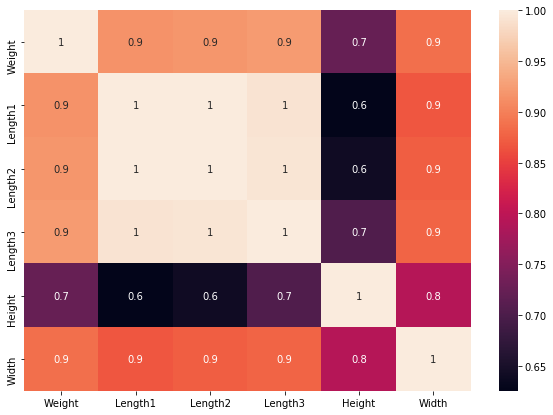

In [44]:
plt.figure(figsize = (10,7))
sns.heatmap(fish.corr(), annot = True, fmt='.1g')

The high correlation between the weight and other elements

In [45]:
fish.drop(columns  =["Length1", 'Length2', 'Length3'], inplace = True)

In [46]:
fish

,Species,Weight,Height,Width
0,Bream,242.0,11.5200,4.0200
1,Bream,290.0,12.4800,4.3056
2,Bream,340.0,12.3778,4.6961
3,Bream,363.0,12.7300,4.4555
4,Bream,430.0,12.4440,5.1340
...,...,...,...,...
154,Smelt,12.2,2.0904,1.3936
155,Smelt,13.4,2.4300,1.2690
156,Smelt,12.2,2.2770,1.2558
157,Smelt,19.7,2.8728,2.0672


In [47]:
Xf = fish[['Height', 'Width']]
yf = fish['Weight']

In [48]:
X_ftrain, X_ftest, y_ftrain, y_ftest = train_test_split(Xf, yf, test_size = 0.2)

In [153]:
lr = LinearRegression()
lr.fit(X_ftrain, y_ftrain)
print(lr.score(X_ftrain, y_ftrain))
y_fpred = lr.predict(X_ftest)
print(f'The R2_score:{r2_score(y_ftest, y_fpred)}')
print(f'The RMSE score {np.sqrt(mean_squared_error(y_ftest, y_fpred))}')

0.7847170157283766
The R2_score:0.7881566752409006
The MSE score 136.60465927910937


### Polynomial

In [152]:
poly = PolynomialFeatures(degree=5) #After adjusting, degree = 5 gives the best result
X_poly = poly.fit_transform(Xf)
X_train, X_test, y_train, y_test = train_test_split(X_poly, yf, test_size = 0.2)
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
y_fpred = lr.predict(X_test)
print(f'The R2_score:{r2_score(y_ftest, y_fpred)}')
print(f'The RMSE score {np.sqrt(mean_squared_error(y_ftest, y_fpred))}')

0.8986044878332407
The R2_score:-0.6617942769530816
The RMSE score 382.60157191364806
